# <font size="7"> **Assignment-6**</font>
I hope this assignment will give you clarity on how mathematical models like **Multilayer Perceptrons (MLP)** can be made from scratch using **PyTorch** & can be used to solve complex, non-linear geometric problems **without relying on black-box libraries**.

---
# ⚫ **Mission Critical: The Exclusion Zone Protocol**

**Date:** Year 2142  
**Location:** Exoplanet *Kepler-186f*   **Clearance:** IITians

---

### **⚫ The Story**
Humanity has colonized the distant exoplanet *Kepler-186f*. While the surface is habitable, the planet's magnetic core is unstable. The **Global Defense Council (GDC)** has identified a dangerous phenomenon known as the **"Radiation Ring."**

Sensors indicate that the safe zones on the planet follow a peculiar geometry:
* ⚫ **The Core Zone:** Distance $< 2$ km from the colony center (Safe).
* ⚫ **The Outer Wilds:** Distance $> 4$ km from the colony center (Safe).
* ⚫ **The Dead Zone:** The region **between 2 km and 4 km** is flooded with lethal gamma radiation.

Your engineering team has deployed **3,000 sensor drones** across the colony to map this danger. Each drone reports its coordinates $(x, y)$ and a binary label:
* `1`: Radiation Detected (Dead Zone)
* `0`: Safe Zone

 **⚫ The Problem:** The sensors are cheap and prone to interference. Approximately **5%** of the drones are malfunctioning and reporting the wrong safety status (noise). The GDC mainframe is a legacy system that forbids the use of modern "Neural Libraries" (i.e., you cannot use `torch.nn` or `torch.optim`). You must build a **Multi-Layer Perceptron (MLP) from scratch** to filter out the noise and mathematically define the Exclusion Zone boundaries using **PyTorch**. ( Hint: You know this is a binary classification problem, which Loss function would you use?? )

---

### **⚫ Your Objective**

1.  **Initialize the System:** Use your **Group Number** as the random seed. This ensures your team works on a unique sensor distribution pattern.
2.  **Architect the Filter:** Construct a neural network with **3 hidden layers** (16 neurons each) to learn the non-linear "donut" shape of the Dead Zone.
3.  **Manual Calibration:** You cannot use auto-optimizers. You must manually calculate the gradients (Backpropagation) and update the system weights using **Gradient Descent**.
4.  **Verify Integrity:** Split your sensor data (70% training, 30% validation). Prove that your system doesn't just memorize the malfunctioning sensors (overfitting) but actually learns the geometric shape of the Dead Zone.

---

## ⚫ Engineering Constraints (Read Carefully)

**1. Restricted Modules**
*  **Forbidden:** You are strictly forbidden from importing `torch.nn` (Layers/Loss) or `torch.optim` (Optimizers).
*  **Allowed:** `import torch`, `import matplotlib.pyplot`, `import pandas`, `import numpy`, using `sklearn`.


**2. The Mechanics**
* **Forward Pass:** Must be implemented using raw matrix multiplication (`torch.matmul`) and bias addition.
* **Backward Pass:** You **MAY** use `loss.backward()` to compute gradients automatically (Autograd).
* **Optimization:** You **MUST** implement the weight updates manually (Stochastic Gradient Descent).
    > `w_new = w_old - learning_rate * w_old.grad`

**3. Loss Function**
Since `torch.nn` is banned, you must implement **Binary Cross Entropy** manually using basic tensor math.

$$Loss = -\frac{1}{N} \sum_{i=1}^{N} [y_i \cdot \log(\hat{y}_i) + (1-y_i) \cdot \log(1-\hat{y}_i)]$$

* **Note:** Ensure you handle the log of zero (numerical stability) or use `torch.clamp` to avoid `NaN` errors.

**4. Visual Proof:** Your final output must include a Decision Boundary Map showing the "Donut" shape.


---

### ⚫ **The GDC Dashboard (Required Output)**



The Global Defense Council requires visual confirmation that your system is stable before we can upload it to the drone fleet. You must generate a **3-Panel Heads-Up Display (HUD)** containing the following telemetry:

**1. System Error Trajectory (Loss Plot)**
* **Mission:** Plot the **Training Loss** (Blue) vs. **Validation Loss** (Orange) over all epochs.
* **Why:** We need to confirm that the system is actually learning and not just diverging (exploding gradients).

**2. Integrity Check (Accuracy Plot)**
* **Mission:** Plot the **Training Accuracy** vs. **Validation Accuracy**.
* **Why:** If Training Accuracy is high (95%) but Validation Accuracy is low (80%), you have failed to generalize. This is a sign of **Overfitting**—memorizing sensor noise instead of the Radiation Ring.

**3. Geospatial Threat Map (Decision Boundary)**
* **Mission:** Visualize the **Validation Set** on a 2D map.
* **Overlay:** Draw the neural network's **Decision Boundary** (the contours where confidence = 0.5).
* **Why:** The Commander needs to *see* the "Donut" shape. If your boundary looks like a jagged mess, the model is rejected.

---

In [4]:
import torch
import numpy as np
# ===========================================================
# PART 1: Data Generation (The Exclusion Zone)
# ===========================================================

# ⚠️ INSTRUCTION: Replace 1 with your actual Group Number
GROUP_NUMBER = 10

# Set seed for reproducibility
torch.manual_seed(GROUP_NUMBER)
np.random.seed(GROUP_NUMBER)

def generate_data(n_samples=3000):
    """
    Generates 3000 sensor readings for the Kepler-186f Exclusion Zone.
    Shape: Concentric circles (Donut).
    Logic:
      - Dead Zone (1): 2km < distance < 4km
      - Safe Zone (0): distance < 2km OR distance > 4km
    """
    # Generate random coordinates between -5 and 5 km
    X = (torch.rand(n_samples, 2) * 10) - 5

    # Calculate distance from center (radius)
    radius = torch.sqrt(X[:, 0]**2 + X[:, 1]**2)

    # Assign Labels: 1 if inside the Dead Zone, 0 otherwise
    y = ((radius > 2) & (radius < 4)).float().view(-1, 1)

    # Add 5% Noise (Malfunctioning Drones)
    n_noise = int(0.05 * n_samples)
    noise_indices = torch.randperm(n_samples)[:n_noise]
    y[noise_indices] = 1 - y[noise_indices] # Flip labels

    return X, y

# Generate the dataset
X_full, y_full = generate_data(3000)

print(f"Data Generated: {X_full.shape} samples.")
print(f"Target Generated: {y_full.shape} labels.")

Data Generated: torch.Size([3000, 2]) samples.
Target Generated: torch.Size([3000, 1]) labels.


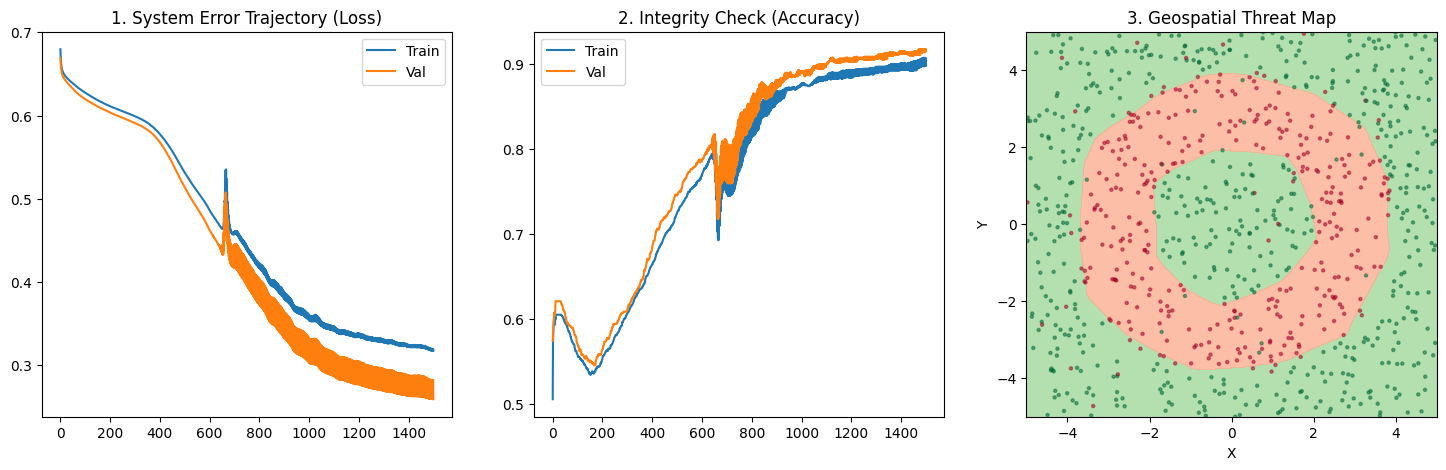

In [6]:

import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Helper function for weight initialization
def init_w(in_d, out_d):
    w = torch.randn(in_d, out_d) * torch.sqrt(torch.tensor(1.0 / in_d))
    return w.requires_grad_(True)

# Helper function to initialize bias terms to zero
def init_b(out_d):
    return torch.zeros(1, out_d, requires_grad=True)

# Defining Network Layers: Input layer(2) -> Hidden layer1 -> Hidden layer 2 -> Output layer(1)
W1, b1 = init_w(2, 16), init_b(16)   # Layer 1
W2, b2 = init_w(16, 16), init_b(16)  # Layer 2
W3, b3 = init_w(16, 16), init_b(16)  # Layer 3
W4, b4 = init_w(16, 1), init_b(1)    # Output Layer

# List of all weights and biases to update during optimization
parameters = [W1, b1, W2, b2, W3, b3, W4, b4]

# Activation Functions
def relu(z): return torch.maximum(torch.tensor(0.0), z) # Zero out the negative values
def sigmoid(z): return 1 / (1 + torch.exp(-z))          # Sigmoid function to limit values between 0 and 1

# Manual Binary Cross Entropy Loss function
def bce_loss(y_pred, y_true):
    y_pred = torch.clamp(y_pred, 1e-7, 1 - 1e-7)   # avoiding log(0) error
    return -torch.mean(y_true * torch.log(y_pred) + (1 - y_true) * torch.log(1 - y_pred))    # Applying BCE formula: - [y * log(y_hat) + (1-y) * log(1-y_hat)]

# Splitting data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_full, y_full, test_size=0.3, random_state=GROUP_NUMBER)

def forward(X):
    # Layer 1 forward pass
    z1 = torch.matmul(X, W1) + b1
    a1 = relu(z1)
    # Layer 2 forward pass
    z2 = torch.matmul(a1, W2) + b2
    a2 = relu(z2)
    # Layer 3 forward pass
    z3 = torch.matmul(a2, W3) + b3
    a3 = relu(z3)
    # Output layer with sigmoid for calculating probability
    z4 = torch.matmul(a3, W4) + b4
    return sigmoid(z4)

lr = 0.1
epochs = 1500
logs = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

for epoch in range(epochs):
    # 1. Forward Pass on training data
    preds = forward(X_train)
    loss = bce_loss(preds, y_train)

    # 2. Backward Pass
    loss.backward()

    # 3. Manual Gradient Descent
    with torch.no_grad(): # Temporarily disabling tracking for weight updates
        for p in parameters:
            p -= lr * p.grad  # Updating weight as linear formula
            p.grad.zero_()    # Reset gradients to zero for next epoch

    # 4. Recording performance (learning capacity) of neural network
    with torch.no_grad():
        val_preds = forward(X_val)   # Passing the validation set
        val_loss = bce_loss(val_preds, y_val)  # Calculating the validation loss
        # Calculating probability (threshold at 0.5) probablity < 0.5 will be safe zone otherwise dead zone
        t_acc = ((preds > 0.5).float() == y_train).float().mean()
        v_acc = ((val_preds > 0.5).float() == y_val).float().mean()

        logs['train_loss'].append(loss.item())
        logs['val_loss'].append(val_loss.item())
        logs['train_acc'].append(t_acc.item())
        logs['val_acc'].append(v_acc.item())

fig, ax = plt.subplots(1, 3, figsize=(18, 5))

# Plotting trajectory loss across all epchoes
ax[0].plot(logs['train_loss'], label='Train')
ax[0].plot(logs['val_loss'], label='Val')
ax[0].set_title("1. System Error Trajectory (Loss)")
ax[0].legend()

# Accuracy plot
ax[1].plot(logs['train_acc'], label='Train')
ax[1].plot(logs['val_acc'], label='Val')
ax[1].set_title("2. Integrity Check (Accuracy)")
ax[1].legend()

# Geospatial threat map

# Creating a grid across the planet surface
x_range = torch.linspace(-5, 5, 100)
y_range = torch.linspace(-5, 5, 100)
grid_x, grid_y = torch.meshgrid(x_range, y_range, indexing='ij')
grid_input = torch.stack([grid_x.reshape(-1), grid_y.reshape(-1)], dim=1)

# Getting model predictions for the entire grid
with torch.no_grad():
    boundary = forward(grid_input).reshape(100, 100)

# Filling the map (Red for dead zone, green for Safe zone)
ax[2].contourf(grid_x, grid_y, boundary, levels=[0, 0.5, 1], colors=['#a1d99b', '#fcae91'], alpha=0.8)
ax[2].scatter(X_val[:, 0], X_val[:, 1], c=y_val.flatten(), s=5, cmap='RdYlGn_r', alpha=0.5)
ax[2].set_title("3. Geospatial Threat Map")
ax[2].set_xlabel("X")
ax[2].set_ylabel("Y")
plt.show()

